In [1]:
!pip install nltk

You are using pip version 9.0.1, however version 10.0.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [216]:
import numpy as np 
import pandas as pd    
import bs4 as bs
import nltk
from nltk.tokenize import sent_tokenize
import re
from nltk.stem import PorterStemmer
from nltk.tag import pos_tag
from nltk import sent_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
from nltk import word_tokenize, sent_tokenize

import dynamic_coattention_network_plus.question_answering.preprocessing.squad_preprocess as prepro

import tensorflow as tf

data_dir = 'data/'
train = pd.read_csv(data_dir + "train.csv", encoding="utf-8")
train.head()

[nltk_data] Downloading package punkt to /Users/Arnav/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Arnav/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [274]:
# small sample dataset
small = train.sample(n = 10)
small.tail(30)

,id,qid1,qid2,question1,question2,is_duplicate
400822,400822,152874,534186,What is the limit on withdrawal through a with...,How do I transfer a fixed deposit account from...,0
62499,62499,108922,108923,How do I start a drone business?,How much does it cost to start a drone business?,1
336514,336514,463880,463881,What episode does Temari have her hair down?,How do I smooth down cowlicks in my hair?,0
330481,330481,457266,457267,"Hlo please help I also want to leran hacking, ...",Why don't shipping companies put ads (food ads...,0
22458,22458,37558,42138,What's the least painful way to die?,Which is the least painful way to die?,1
282105,282105,401987,401988,Which laptop should I buy under range of 35K Rs?,Which laptop should I buy in the range of 45K?,0
402464,402464,60904,63160,How do I make a music video with photos?,How can i find a music video?,0
200277,200277,302004,302005,Why don't left government of Kerala merge in P...,What's the best way to reject someone (especia...,0
48842,48842,37339,43413,Who do you think will win the 2016 presidentia...,Who will win the 2016 United States Presidenti...,1
293511,293511,415283,206982,What is the difference between 18-55mm and 18-...,What should I do whether I have Canon 18-55 + ...,0


In [275]:
def remove(sentence, regex, lemmatize = False):
    #[^a-zA-Z]
    #print(sentence)
    ret = sentence
    #ret = re.sub(regex,' ', ret)
    
    ret = ret.lower()
    
    ret = word_tokenize(ret) #uses punkt tokenizer
    
    #ps = PorterStemmer()
    #ret = [ps.stem(x) for x in ret]
    
    if lemmatize:
        wnl = WordNetLemmatizer()
        ret = [wnl.lemmatize(x) for x in ret]
    
    return ret

def remove_dcn(sentence, lemmatize = False):
    #[^a-zA-Z]
    ret = sentence
    ret = ret.lower()
    
    ret = prepro.tokenize(ret) #uses punkt tokenizer
    if lemmatize:
        wnl = WordNetLemmatizer()
        ret = [wnl.lemmatize(x) for x in ret]
    
    return ret

ind = 5
print(small['question1'].apply(lambda x: remove(x, "")).iloc[ind])
print(small['question1'].apply(lambda x: remove_dcn(x)).iloc[ind])

[u'which', u'laptop', u'should', u'i', u'buy', u'under', u'range', u'of', u'35k', u'rs', u'?']
[u'which', u'laptop', u'should', u'i', u'buy', u'under', u'range', u'of', u'35k', u'rs', u'?']


In [277]:
# Make Dictionary of id to unique, cleaned questions 
# Also fill dictionary with encountered words

id2q = {}
vocab = {}
for index, row in train.iterrows():
    if not row['qid1'] in id2q:
        word_list = remove_dcn(row['question1']) #remove(row['question1'], '')
        vocab.update({v:1 for v in word_list})
        id2q[row['qid1']] = word_list
    if not row['qid2'] in dictionary:
        word_list = remove_dcn(row['question2']) #remove(row['question2'], '')
        vocab.update({v:1 for v in word_list})
        id2q[row['qid2']] = word_list


In [278]:
print("Number of Unique Questions: " + str(len(id2q)))
print(id2q[80])
#print(id2q[667])
#print(id2q[663])

print("")
print("Unique Vocab Size " + str(len(vocab)))

Number of Unique Questions: 290654
[u'why', u'did', u'aircraft', u'stop', u'using', u'variable-sweep', u'wings', u',', u'like', u'those', u'on', u'an', u'f-14', u'?']

Unique Vocab Size 83782


In [233]:
# Import Glove Embeddings 
import io 

In [279]:
# write GloVe vocab to textfile
def record_vocab(file, file_name):
    to_write = io.open(file_name, 'a', encoding="utf-8")
    
    for line in f:
        values = line.split()
        word = values[0]
        to_write.write(word+'\n')
        pass
    to_write.close()
    return 
# load the whole embedding into memory
f = io.open(data_dir + "glove.6B/" + 'glove.6B.50d.txt', mode='r', encoding="utf-8")
record_vocab(f, data_dir + "glove.6B/" + 'glove_vocab.txt')
f.close()

IOError: [Errno 2] No such file or directory: 'data/glove.6B/glove.6B.50d.txt'

In [280]:
# load the whole embedding into memory
embeddings_dir = "dynamic-coattention-network-plus/download/dwr/"
f = io.open(embeddings_dir + 'glove.6B.100d.txt', mode='r', encoding="utf-8")
embeddings = {}
for line in f:
    values = line.split()
    word = values[0]
    if word in vocab:
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings[word] = coefs
    pass
print('Loaded %s word vectors.' % len(embeddings))
f.close()

Loaded 53837 word vectors.


In [281]:
avg_oov_per_q = 0
avg_oov_ratio_per_q = 0
qs_with_oov = 0
avg_oov_q_with_oov = 0
oov_counts = []
q_count = len(id2q)
for v in id2q.values():
    oov_count = 0
    oov_ratio = 1
    for w in v:
        if not w in embeddings:
            oov_count += 1.
        pass
    avg_oov_per_q += oov_count/q_count
    avg_oov_q_with_oov += int(oov_count > 0.5)*oov_count
    
    if oov_count>.5:
        oov_counts.append(oov_count)
    
    avg_oov_ratio_per_q += (oov_count/len(v))/q_count
    qs_with_oov += int(oov_count > 0.5)
    
    pass

print("Average OOV Count Per Quesiton: " + str(avg_oov_per_q))
print("Average OOV Count For Questions with an OOV: " + str(avg_oov_q_with_oov/qs_with_oov))
print("Median OOV Count For Questions with an OOV: " + str(np.median(oov_counts)))

print("Average OOV Ratio Per Quesiton: " + str(avg_oov_ratio_per_q))
print("Fraction of Quesitons with OOV: " + str(1.*qs_with_oov/q_count))


Average OOV Count Per Quesiton: 0.15350898319
Average OOV Count For Questions with an OOV: 1.26353647485
Median OOV Count For Questions with an OOV: 1.0
Average OOV Ratio Per Quesiton: 0.0121782384484
Fraction of Quesitons with OOV: 0.121491532888


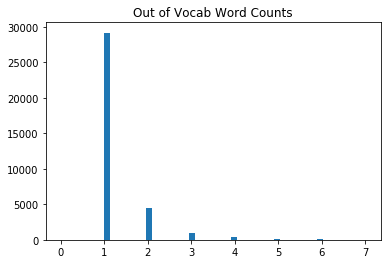

In [282]:
from matplotlib import pyplot as plt
plt.hist(oov_counts, 50, range = (0,7))
plt.title('Out of Vocab Word Counts')
plt.show()